# Using object orientation for anomaly detection

This Python3 notebook was written to become familiar with **object orientation in Python**. It shows how to possibly implement an anomaly detector class using **multivariate Gaussians** to represent the training data. It is assumed that the training data isn't labeled. A second data set, which is assumed to be labeled, is used for cross validation, namely to find the best possible threshold to mark an observation as an anomaly / outlier. The performance measure, used, is the **F1 score**.

In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import inv, det
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import seaborn as sns
from sklearn.model_selection import train_test_split

# Helper functions and class definitions for modeling

In [2]:
def multivariateGaussian(X,mu,covmat):
    '''
    p = multivariateGaussian(X,mu,covmat) calculates the multivariate 
    density function of dataframe X with respect to mu and covmat.
    Each feature corresponds to one dimension. mu is a Series
    with the same index names as X and corresponds to the mean. covmat 
    represents the covariance matrix. In case of uncorrelation it
    my be given as a Series.
    '''
    if len(covmat.shape) == 1:
        covmat = np.diag(covmat)
    A = np.exp(-0.5*(X-mu).apply(lambda x: x.T.dot(inv(covmat)).dot(x),axis=1))
    return (1/np.sqrt((2*np.pi)**len(mu)*det(covmat))*A)

In [3]:
def performance(yval,pval,epsilon):
    '''
    precision, recall, F1 = f1score(yval,pval,epsilon) calculates the 
    precision, the recall, and the F1 score.
    
    yval: true labels
    pval: density values
    epsilon: decision value
    '''
    tp = sum(yval[pval < epsilon]) # true positives
    fn = sum(yval[pval >= epsilon]) # false negatives
    fp = sum((pval < epsilon) & (yval==0)) # false positives
    tn = sum((pval >= epsilon) & (yval==0)) # true negatives
    try:
        prec = tp/(tp+fp) # precision
        rec = tp/(tp+fn) # recall
        return prec, rec, 2*prec*rec/(prec+rec) # F1 score
    except:
        return None, None, None

In [4]:
def selectThreshold(yval,pval):
    '''
    epsilon, F1 = selectThreshold(yval,pval) finds the threshold
    epsilon for the anomaly detection that gives the best precision
    recall tradeoff, namely the best F1 score, for a cross validation
    set. yval are the true labels and pval corresponds to the predicted
    probabilities.
    '''
    bestEpsilon, bestF1, F1 = 0,0,0 # initialization
    stepsize = (max(pval) - min(pval)) / 1000 # stepsize for testing thresholds
    #for epsilon in np.arange(min(pval),max(pval),stepsize): # walk through all possible thresholds
    for epsilon in np.unique(pval):
        prec, rec, F1 = performance(yval,pval,epsilon)
        if F1 is not None:
            if F1 > bestF1: # save currently best threshold
                bestF1, bestEpsilon = F1, epsilon
            if prec-rec < 0:
                return bestEpsilon, bestF1
    return bestEpsilon, bestF1

In [5]:
def copyOrOriginal(df, copy = False):
    '''
    df_new = copyOrOiginal(df,copy) returns either the original
    data frame or a copied one, depending on the copy flag.
    '''
    if copy:
        return df.copy()
    return df

In [6]:
class DataSet(pd.DataFrame):
    '''
    DataSet class inherits from pandas DataFrame and adds some
    new functionality, such as to lower the feature names and
    to check whether the data frame contains a "label" column.
    '''
    
    def __init__(self,data):
        super().__init__(data)
    
    @property
    def _constructor(self):
        '''Set constructor attribute to get the correct class back when slicing.'''
        return DataSet

    def colnamesToLower(self):
        '''self.colnamesToLower() lowers all letters of the column names.'''
        self.columns = [x.lower() for x in list(self.columns)]
    
    @property
    def isLabeled(self):
        '''self.isLabeled checks wheter self contains a column called "label".'''
        if 'label' in self.columns:
            return True
        return False

In [7]:
class FeatureError():
    '''Custom exception raised when feature names mismatch for prediction and plotting.'''
    pass

In [8]:
class AnomalyDetector():
    '''AnomalyDetector class can perform semi-supervised learning to detect
    anomalies / outliers. The idea is to have a large set of unlabeled data 
    and a small set of labeled data. The unlabeled data is used to build a 
    probability model. So far only multivariate Gaussian is implemented. The
    labeled data is used as cross validation data set to find the best threshold
    when to mark a new, unlabeled data point as an anomaly.
    
    model = AnomalyDetector(train,cv,copy)
    
    train:  dataframe of unlabeled data
    cv:     dataframe of labeled data (needs to have a column called "label" and must contain the
            same features as train - no case sensitivity required.)
    copy:   wheter or not to work on copies of the original data (default: False)
    '''
    
    def __init__(self,train,cv,copy = False):
        self.__copy = copy
        self.train = train
        self.cv = cv
        self.reset()
    
    @property
    def train(self):
        return self.__train
    
    @train.setter
    def train(self,train):
        '''
        Whenever the train attribute is set, this setter is called to 
        transform it to a DataSet instance, lowers the feature names, 
        and resets the model.
        '''
        ds = copyOrOriginal(train,self.__copy)
        self.__train = DataSet(ds)
        self.__train.colnamesToLower()
        self.reset()
    
    @property
    def cv(self):
        return self.__cv
        
    @cv.setter
    def cv(self,cv):
        '''
        Whenever the cv attribute is set, this setter is called to 
        transform it to a DataSet instance, lowers the feature names, 
        makes sure a label column is present, extracts the used features,
        and resets the model.
        '''
        ds = DataSet(copyOrOriginal(cv,self.__copy))
        ds.colnamesToLower()
        assert ds.isLabeled, "Cross validation data set must provide a column called 'label'."
        try:
            self.__cv = ds[list(self.features)+["label"]]
            self.reset()
        except KeyError:
            print("Make sure cross validation set contains same features than training set!")
    
    @property
    def features(self):
        '''features attribute stores the feature names'''
        return self.train.columns
        
    @property
    def mu(self):
        '''The mu attribute stores the mean of the training set.'''
        return self.train.mean()
    
    @property
    def sigma2(self):
        '''The sigma2 attribute stores the variance of the training set.'''
        return self.train.var()
    
    @property
    def covmat(self):
        '''The covmat attribute stores the covariance matrix of the training set.'''
        return np.cov(np.array(self.train).T)
    
    def learn(self):
        '''
        The learn method performs cross validation to find the anomaly 
        threshold with the best F1 score.
        
        model.learn()
        '''
        pval = multivariateGaussian(self.cv[self.features],self.mu,self.covmat)
        self.epsilon, self.F1 = selectThreshold(self.cv['label'],pval)
        
    def predict(self,df = None):
        '''
        The predict method returns the probabilities for the given data frame df
        and the number of marked outliers based on the learned threshold. If
        no data frame is given, the unlabeled training set is used.
        
        p, numberOfOutliers = model.predict() -> use training set
        p, numberOfOutliers = model.predict(newDf) -> predict for new data frame
        '''
        if df is None:
            df = self.train
        if self.epsilon is None:
            return None
        try:
            p = multivariateGaussian(df[self.features],self.mu,self.covmat)
        except KeyError:
            raise FeatureError("Features not found in data set used for prediction.")
        return p, sum(p < self.epsilon)
        
    def reset(self):
        '''
        The reset method resets the threshold and the F1 score.
        
        model.reset()
        '''
        self.epsilon = None
        self.F1 = None
    
    def plot(self,df = None, ax = [0,1], contour = False, **kwargs):
        '''
        The plot method plots data and - when present - also the outliers.
        
        df:      data frame for plotting, default: training set
        ax:      which axes to use, must be 2 list with 2 entries in the range of the features
        contour: True if contour lines should be plotted, default False, because the automatic
                 level calculation does not alway work properly
        kwargs:  additional plotting parameters accepted by the plot function of matplotlib.pyplot
        
        model.plot([0,3], xlabel = "my own x label") 
        -> plot feature 0 and 3 and override default xlabel (feature name)
        '''
        if df is None:
            df = self.train
        names = self.features[ax]
        try:
            plt.plot(df[names[0]],df[names[1]],'.') # scatter plot 
        except KeyError:
            raise FeatureError("Features not found in data set used for plotting.")
        
        for f,val in kwargs.items(): # walk through additional plotting arguments
            try:
                eval('plt.{f}({val!r})'.format(**locals()))
            except: # Ignore the parameter when it doesn't work.
                print('Invalid plot command: ({f},"{val}") Not used'.format(**locals()))
        # default xlabel and ylabel
        if "xlabel" not in kwargs:
            plt.xlabel(names[0])
        if "ylabel" not in kwargs:
            plt.ylabel(names[1])
        # In case learning has already taken place, find and plot outliers, and visualize
        # probability density of the data by contours.
        if self.epsilon is not None:
            p, _ = self.predict(df)
            outliers = df[p < self.epsilon]
            plt.plot(outliers[names[0]],outliers[names[1]],'or',mfc='none',markersize=10)
            # The rest of the method creates data and levels for the contour plot.
            if contour:
                left = df[names].min()
                right = df[names].max()
                step = (right-left)/50
                off = (right-left)*0.25
                x = []
                for l,r,s,o in zip(left,right,step,off):
                    x.append(np.arange(l-o,r+o,s))
                X,Y = np.meshgrid(*x)
                Z = multivariateGaussian(pd.DataFrame(np.stack([X.ravel(),Y.ravel()]).T,
                                                      columns=names),self.mu,self.covmat)
                Z = Z.values.reshape(X.shape)
                logrange = np.log10([p.min(),p.max()])
                levels = 10.0**np.arange(*logrange,np.floor((logrange[1]-logrange[0])/7))
                plt.contour(X,Y,Z,levels = levels)
        
    def report(self,*args,copy = False):
        '''
        The report method reports some results of a learned model.
        args correspond to additional dataframes, such as test sets with or without labels.
        If copy is set to true, the original data set remains untouched in terms of 
        column names.
        '''
        if self.epsilon is None:
            print("No model learned, yet. Nothing to report.")
        else:
            print("Threshold found by cross validation: {0.epsilon}\nResulting F1 score: {0.F1}".format(self))
            print("Number of found outliers in cross validation set:",self.predict(self.cv)[1])
            print("Number of points labeled as outliers:",sum(self.cv["label"]==1))
            print("Number of predicted outliers in training set:",self.predict()[1])
            for i,df in enumerate(args,start=1):
                df = DataSet(copyOrOriginal(df,copy))
                df.colnamesToLower()
                try:
                    if df.isLabeled:
                        df = df[list(self.features) + ["label"]]
                    else:
                        df = df[self.features]
                except KeyError:
                    print("Features in additional reporting set do not match. It's ignored.")
                    continue
                print("Number of found outliers in test set {0}: {1}".format(
                    i,self.predict(df[self.features])[1]))
                if df.isLabeled:
                    print("Number of points labeled as outliers in test set {0}: {1}".format(
                        i,sum(df["label"]==1)))
                    pval = multivariateGaussian(df[self.features],self.mu,self.covmat)
                    _, _, F1 = performance(df.label,pval,self.epsilon)                    
                    print("Corresponding F1 score:",F1)

# Testing the anomaly detector class

A very simple dataset is used for a first test describing response data of a server.

## Load and visualize data, initialize model

In [9]:
names = ("Latency","Throughput")
train = pd.read_csv("data/train.csv",header=None,names=names)
cv = pd.read_csv("data/cv.csv",header=None,names=names+("label",))

In [10]:
train.head()

,Latency,Throughput
0,13.047,14.741
1,13.409,13.763
2,14.196,15.853
3,14.915,16.174
4,13.577,14.043


In [11]:
model = AnomalyDetector(train,cv,copy = True)

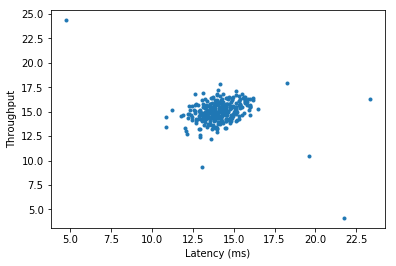

In [12]:
model.plot(xlabel = "Latency (ms)", ylabel = "Throughput")

## Learning a model

In [13]:
model.learn()

In [14]:
model.report()

Threshold found by cross validation: 0.00030276756052180487
Resulting F1 score: 0.8750000000000001
Number of found outliers in cross validation set: 7
Number of points labeled as outliers: 9
Number of predicted outliers in training set: 6


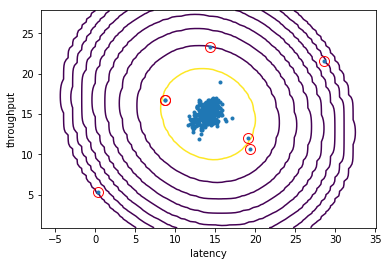

In [15]:
# visualize the cross validation set
model.plot(model.cv,contour = True)

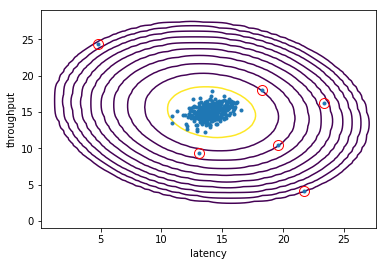

In [16]:
# visualize training set
model.plot(contour = True)

# Testing the anomaly detector class on credit card fraud kaggle data set 

The data set contains credit card transactions, labeled as normal transactions or frauds. The features are preprocessed principal components in addition to time stamp and amount of money. So no information on the "real" features are available. Data can be downloaded from https://www.kaggle.com/mlg-ulb/creditcardfraud/data.

Note that the situation is not the standard semi-supervised learning task, because class labels for the whole data set exists. So, Gaussian estimation is probably not the best thing to do here. Since using the anomaly detector class is the aim of this work, we will see how far we will get.

## Load data

In [17]:
all_data = pd.read_csv("data/creditcard.csv")

In [18]:
all_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [19]:
print("Number of observations:",len(all_data))
print("Number of normal transactions:",sum(all_data.Class==0))
print("Number of frauds:",sum(all_data.Class==1))
print("Ratio of frauds versus normal transaction:",sum(all_data.Class==1)/sum(all_data.Class==0))

Number of observations: 284807
Number of normal transactions: 284315
Number of frauds: 492
Ratio of frauds versus normal transaction: 0.0017304750013189597


**Check for autocorrelation**

(0, 1)

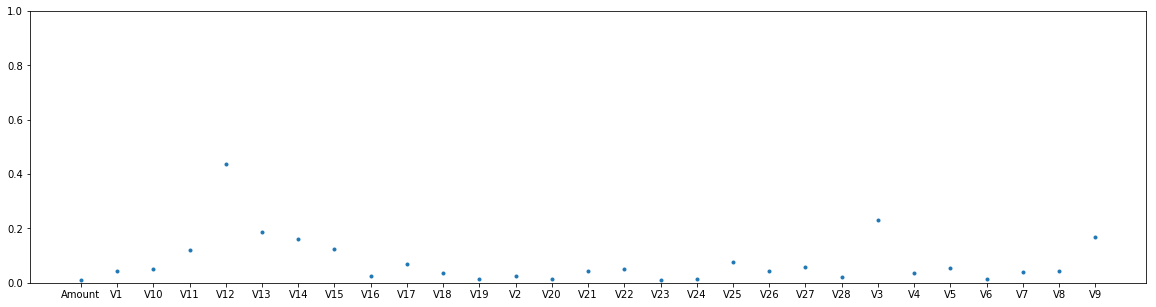

In [20]:
plt.figure(figsize=(20,5))
plt.plot(all_data.drop(columns = ["Time","Class"]).apply(pd.Series.autocorr),'.')
plt.ylim([0,1])

Not so strong autocorrelation -> no time-series methods necessary, time variable will be dropped

## Split in train, cross validation, and test set
Since we know the labels, only normal transactions are used to build the model. A cross validation (cv) set is used to find the best decision threshold and a test set is used for final testing. The splitting for normal transactions is done by 60% / 20% / 20% for train, cv, test and the frauds are split by 50% / 50% for cv and test.

In [21]:
normal = all_data[all_data["Class"]==0] # normal transactions
frauds = all_data[all_data["Class"]==1] # frauds
normal = normal.drop(columns = ["Time"])
frauds = frauds.drop(columns = ["Time"])

In [22]:
cv_frauds, test_frauds = train_test_split(frauds,test_size=0.5, random_state=42)

In [23]:
X, cv_normal = train_test_split(normal,test_size=0.2,random_state=42)

In [24]:
train, test_normal = train_test_split(X,test_size=0.25,random_state=42)

In [25]:
train = train.drop(columns = ["Class"])

In [26]:
cv = pd.concat([cv_normal,cv_frauds])
cv.columns = list(cv.columns[:-1]) + ["label"]

In [27]:
test = pd.concat([test_normal,test_frauds])
test.columns = cv.columns

# Run a first model with all features

In [28]:
features = cv.columns
model = AnomalyDetector(train[features[:-1]],cv[features],copy = True)

In [29]:
model.learn()

In [30]:
model.report(test,copy = True)

Threshold found by cross validation: 1.6819857655693075e-204
Resulting F1 score: 0.6212765957446809
Number of found outliers in cross validation set: 224
Number of points labeled as outliers: 246
Number of predicted outliers in training set: 260
Number of found outliers in test set 1: 246
Number of points labeled as outliers in test set 1: 246
Corresponding F1 score: 0.5934959349593496


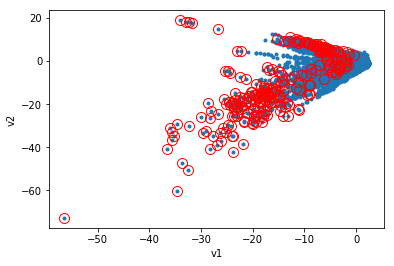

In [31]:
# plot of first 2 dimensions
model.plot()

The F1 score is not the very best and the plot shows that outliers / anomalies seem to cluster in certain regions rather than being far away from the normal transactions. The number of found outliers is not meaningful here as there are both many false negatives and false positives. Let's have a closer look at how the features are distributed.

# Visualize the distribution for all features

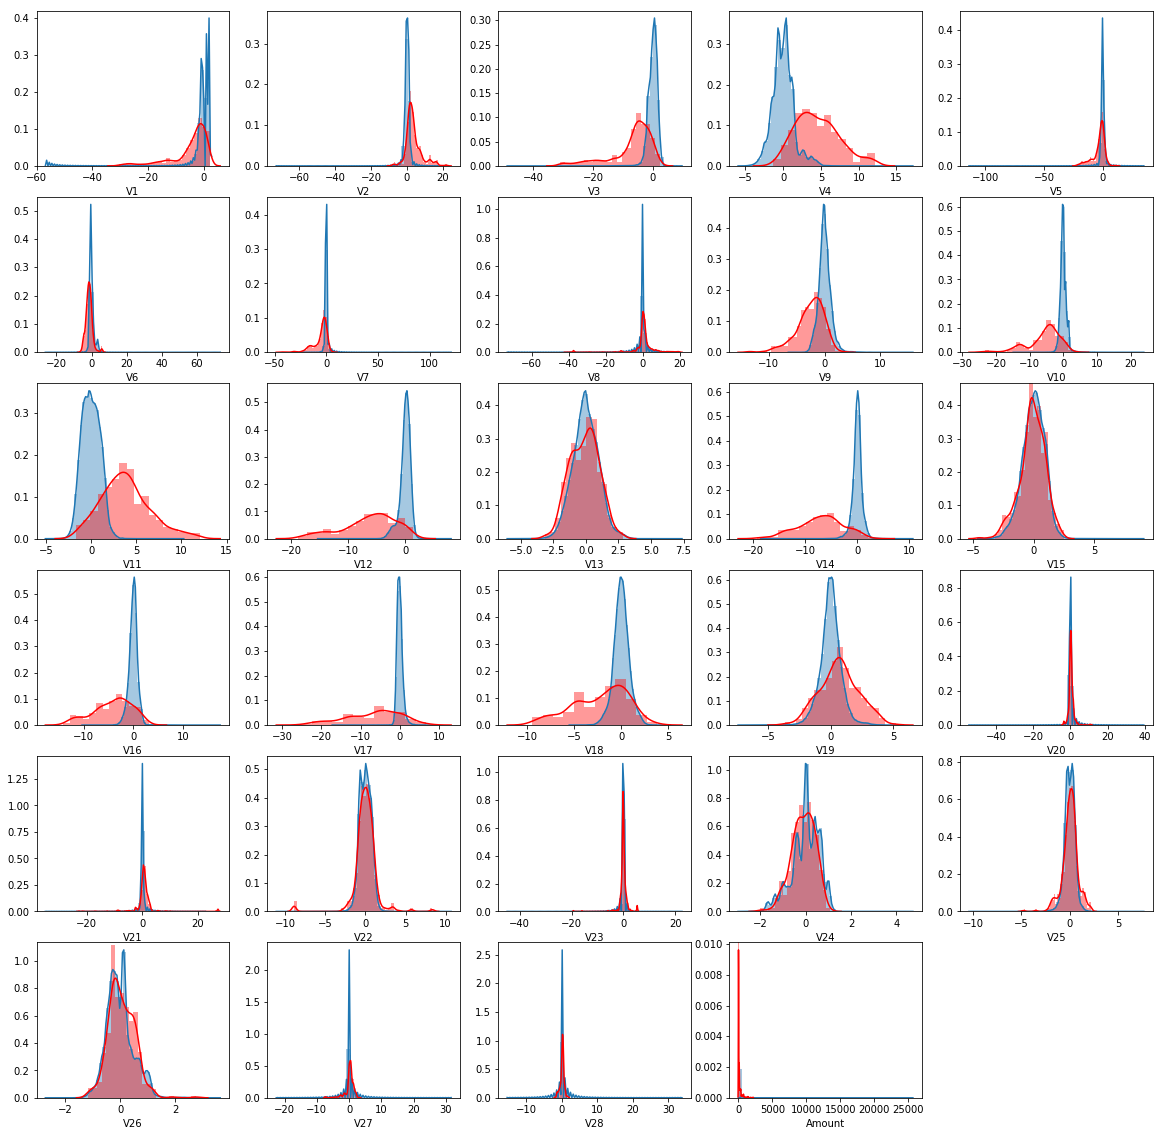

In [32]:
names = features[:-1]
n = len(names)
n2 = int(np.round(np.sqrt(n)))
n1 = n2 if ((n2**2) >= n) else n2+1
plt.figure(figsize=(20,20))
for i,name in enumerate(names,start=1):
    eval("plt.subplot({n1},{n2},{i})".format(**locals()))
    sns.distplot(normal[name],label='normal')
    sns.distplot(frauds[name],color='r',label='fraud')

The histograms show that normal distribution seems to be appropriate for the normal transactions. For some features normal transactions and frauds are distributed very similarly. So, the next idea is to drop these features, as they do not add information to the anomaly detection.

# Run a model with reduced features

Drop V13, V15, V22, V23, V24, V25, V26

In [33]:
features = features.drop(['V13','V15','V22','V23','V24','V25','V26'])
model = AnomalyDetector(train[features[:-1]],cv[features],copy = True)

In [34]:
model.learn()
model.report(test,copy = True)

Threshold found by cross validation: 2.1249658061890912e-168
Resulting F1 score: 0.6653144016227182
Number of found outliers in cross validation set: 247
Number of points labeled as outliers: 246
Number of predicted outliers in training set: 284
Number of found outliers in test set 1: 288
Number of points labeled as outliers in test set 1: 246
Corresponding F1 score: 0.6516853932584269


The F1 score has improved, but there's still room for further improvement. Let's try only the features, for which the distribution for the frauds differ significantly from the normal transactions.

# Run a model with even more reduced features

In [35]:
features = ['V3', 'V4', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18','V19','label']
model = AnomalyDetector(train[features[:-1]],cv[features],copy = True)

In [36]:
model.learn()
model.report(test,copy = True)

Threshold found by cross validation: 1.3626115766210255e-61
Resulting F1 score: 0.8175824175824176
Number of found outliers in cross validation set: 209
Number of points labeled as outliers: 246
Number of predicted outliers in training set: 69
Number of found outliers in test set 1: 230
Number of points labeled as outliers in test set 1: 246
Corresponding F1 score: 0.8151260504201681


The F1 score has improved significantly. To conculude: The model seems to be a first good choice considering its simplicity. However, for really good models more sophisticated models, such as advanced classifiers, are likely to be required.